In [1]:
import sys
import os

In [2]:
import torch
import torch.nn as nn

In [3]:
sys.path.append(os.path.abspath(".."))
from PotteryDataset import create_pottery_dataloaders, create_pottery_datasets, feature_types, feature_type_combos
from PotteryChronologyPredictor import PotteryChronologyPredictor, train

In [ ]:
sys.path.append(os.path.abspath("../.."))
from utils import read_features, read_targets, print_info_features, print_info_targets, encode_labels, train_val_split, \
    get_dimensions, get_device, metrics_c, plot_history

## Settings

In [4]:
# Set Working Device
device = get_device()

PyTorch Version: 2.5.1
CUDA is available
GPU: NVIDIA GeForce RTX 4080
Using Device: cuda


In [5]:
path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/chronology_prediction"))

In [6]:
target = "HistoricalPeriod"

## Data

### Read Features and Targets

In [7]:
X = read_features(path, f_type="tensors")
y = read_targets(path, [target])

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
Loaded y_train
Loaded y_test


In [8]:
print_info_features(X)

{
	train: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 768]), 
	},
	test: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
	},
}


In [9]:
print_info_targets(y)

{
	train: 
		<class 'pandas.core.frame.DataFrame'>
		shape   = (1719, 1)
		columns = ['HistoricalPeriod'],
	test: 
		<class 'pandas.core.frame.DataFrame'>
		shape   = (191, 1)
		columns = ['HistoricalPeriod'],
}


### Encode Target Labels

In [10]:
y, target_enc, le = encode_labels(y, target)

0 --> Archaic
1 --> Classical
2 --> Hellenistic
3 --> Orientalizing


In [11]:
y = {
    subset: torch.tensor(_y[target_enc].values, dtype=torch.long, device=device)
    for subset, _y in y.items()
}
print_info_targets(y)

{
	train: 
		<class 'torch.Tensor'>
		shape   = torch.Size([1719])
	test: 
		<class 'torch.Tensor'>
		shape   = torch.Size([191])
}


### Train-Validation Split


In [12]:
X, y = train_val_split(X, y)

In [13]:
print_info_features(X)

{
	train: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 768]), 
	},
	val: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 768]), 
	},
	test: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2917]), 
		resnet: 
		

In [14]:
print_info_targets(y)

{
	train: 
		<class 'torch.Tensor'>
		shape   = torch.Size([1547])
	val: 
		<class 'torch.Tensor'>
		shape   = torch.Size([172])
	test: 
		<class 'torch.Tensor'>
		shape   = torch.Size([191])
}


### Dimensions

In [15]:
X_dim, y_dim = get_dimensions(X, y, le)

X Dimensions: {'tfidf': 300, 'bert': 768, 'cannyhog': 2917, 'resnet': 2048, 'vit': 768}
y Dimensions: 4


### Torch Datasets and Dataloaders

In [16]:
datasets = create_pottery_datasets(X, y)
loaders = create_pottery_dataloaders(datasets, batch_size=64)

## MLP: Pottery Chronology Predictor - Historical Period Classifier


### Initialize Models

In [17]:
hidden_size = 512

models = {
             ft: PotteryChronologyPredictor([X_dim[ft]], y_dim, hidden_size, device, chronology_target="periods")
             for ft in feature_types
         } | {
             ft_txt + " + " + ft_img: PotteryChronologyPredictor([X_dim[ft_txt], X_dim[ft_img]], y_dim, hidden_size, device, chronology_target="periods")
             for ft_txt, ft_img in feature_type_combos
         }

In [18]:
for ft, model in models.items():
    print(f"\n\nMODEL SUMMARY - FEATURE TYPE: {ft.upper()}")
    model.summary()



MODEL SUMMARY - FEATURE TYPE: TFIDF
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 300]                  [1, 4]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 300]                  [1, 512]                  --                        --
│    │    └─Linear: 3-1                  [1, 300]                  [1, 512]                  154,112                   154,112
│    │    └─ReLU: 3-2                    [1, 512]                  [1, 512]                  --                        --
│    │    └─Dropout: 3-3                 [1, 512]                  [1, 512]                  --                        --
├─Sequential: 1-2                        [1, 512]                  [1, 4]                    -- 

### Train Models

In [19]:
criterion = nn.CrossEntropyLoss()
metrics = {m: metrics_c[m] for m in metrics_c.keys()}



** FEATURE SET: TFIDF **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1060.15it/s, loss=0.8953]


** Early stop | ran: 15/50 epochs | final: epoch 05 | train_loss: 0.4468, val_loss: 0.5010, accuracy: [0.80], precision: [0.39], recall: [0.40], f1: [0.40], 


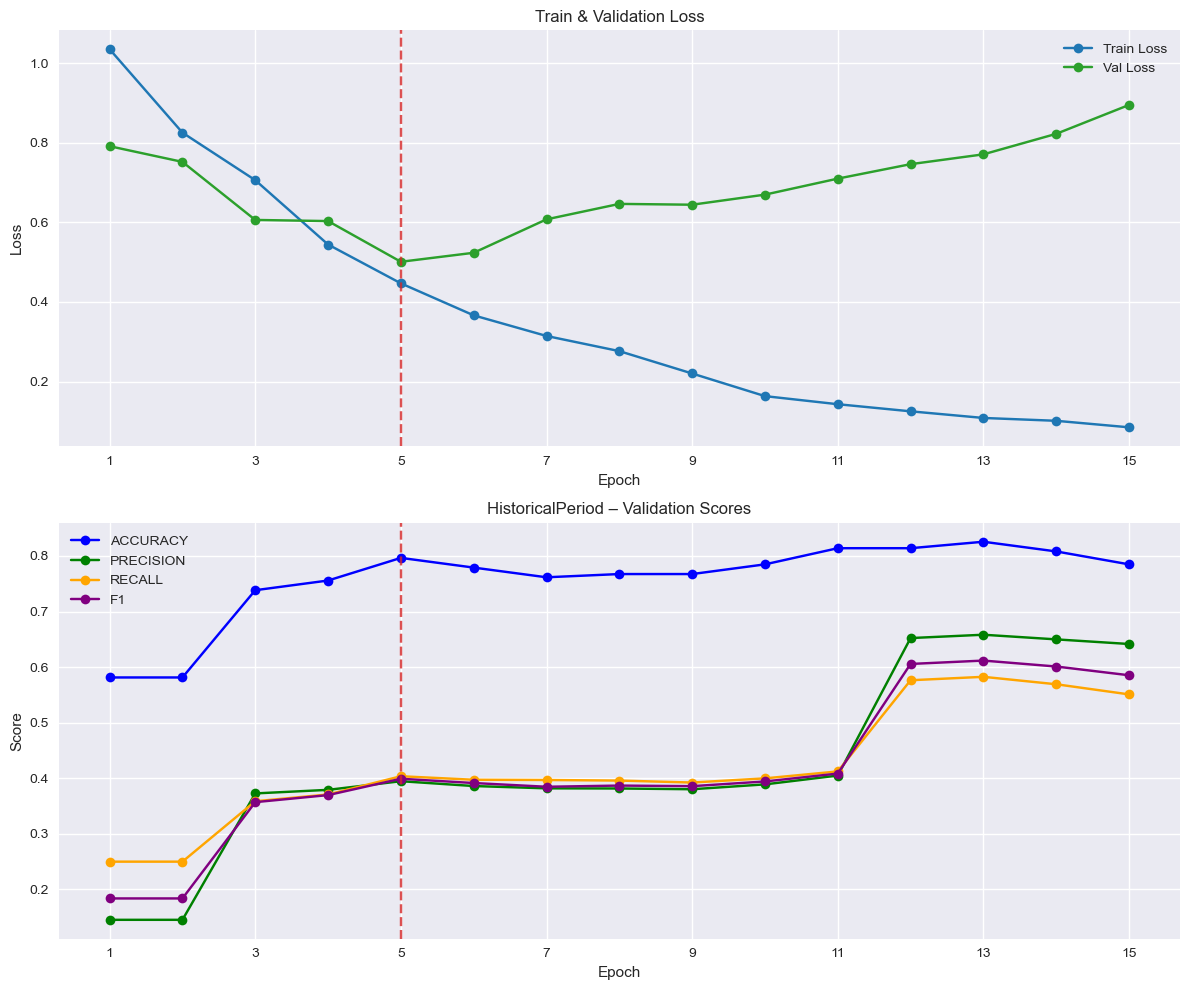



** FEATURE SET: BERT **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1439.53it/s, loss=0.6511]


** Early stop | ran: 28/50 epochs | final: epoch 18 | train_loss: 0.5594, val_loss: 0.6133, accuracy: [0.72], precision: [0.35], recall: [0.36], f1: [0.36], 


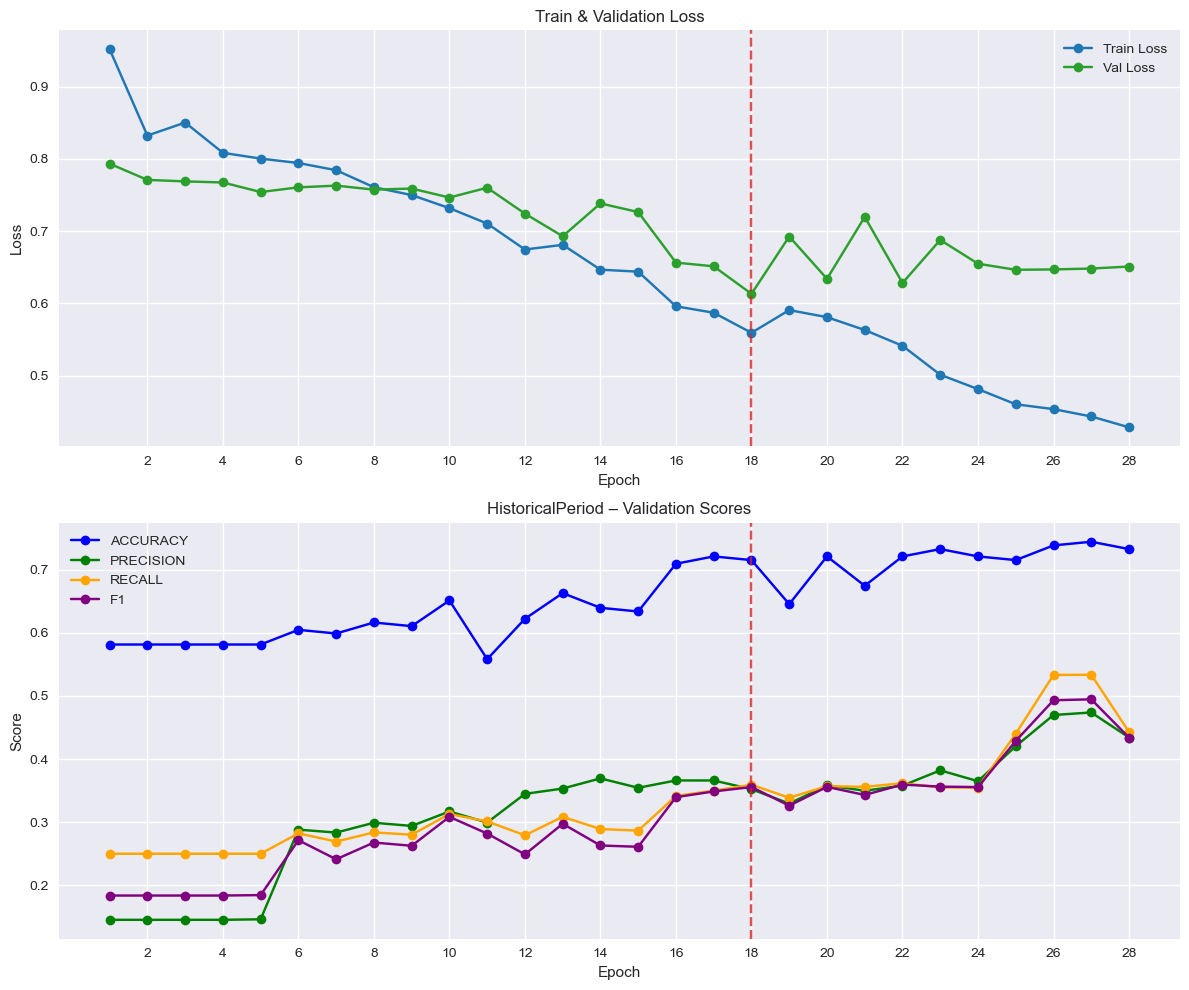



** FEATURE SET: CANNYHOG **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 824.84it/s, loss=0.7752]


** Early stop | ran: 42/50 epochs | final: epoch 32 | train_loss: 0.8007, val_loss: 0.7729, accuracy: [0.58], precision: [0.15], recall: [0.25], f1: [0.18], 


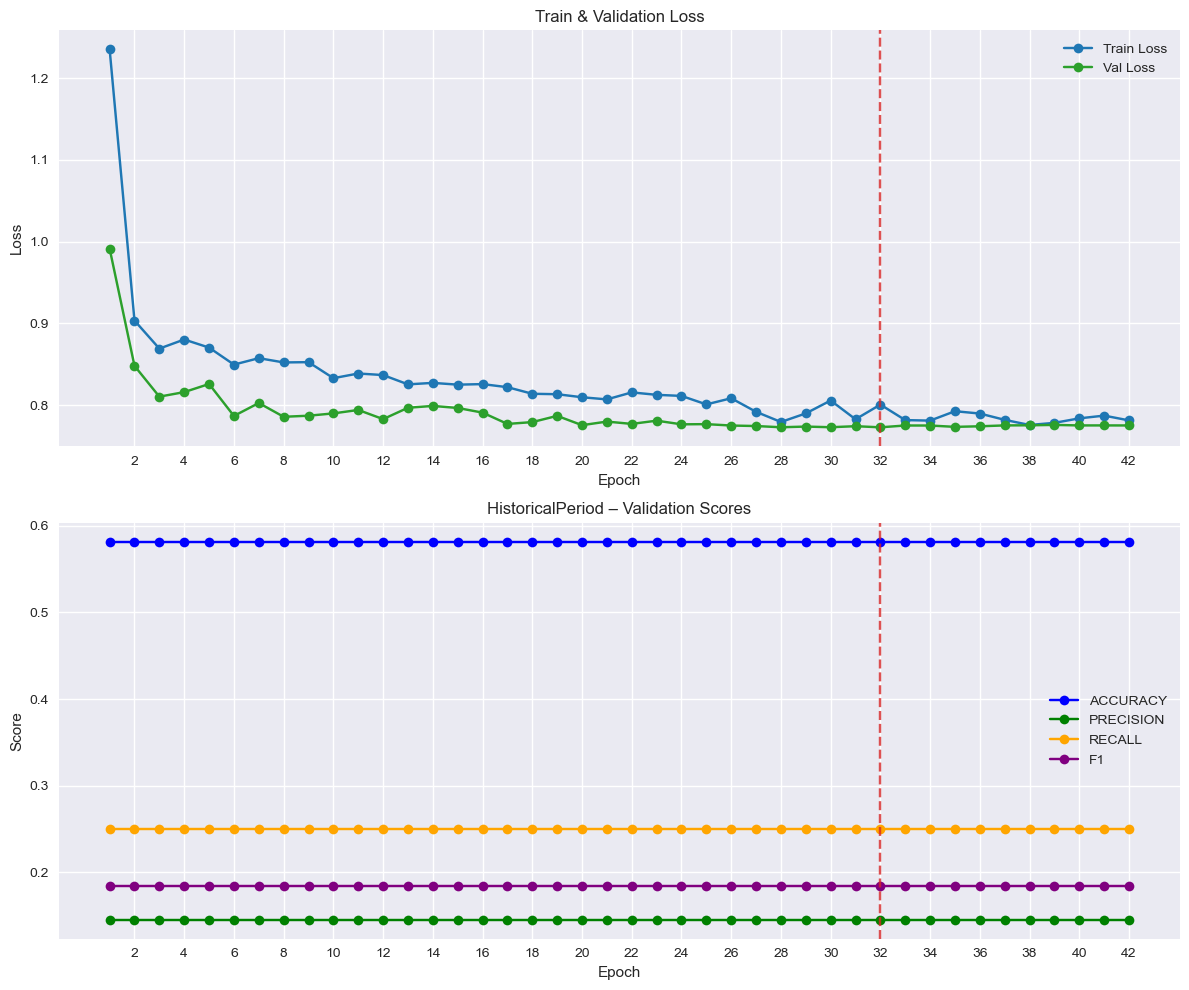



** FEATURE SET: RESNET **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1214.22it/s, loss=0.7808]


** Early stop | ran: 16/50 epochs | final: epoch 06 | train_loss: 0.6666, val_loss: 0.6729, accuracy: [0.70], precision: [0.37], recall: [0.33], f1: [0.32], 


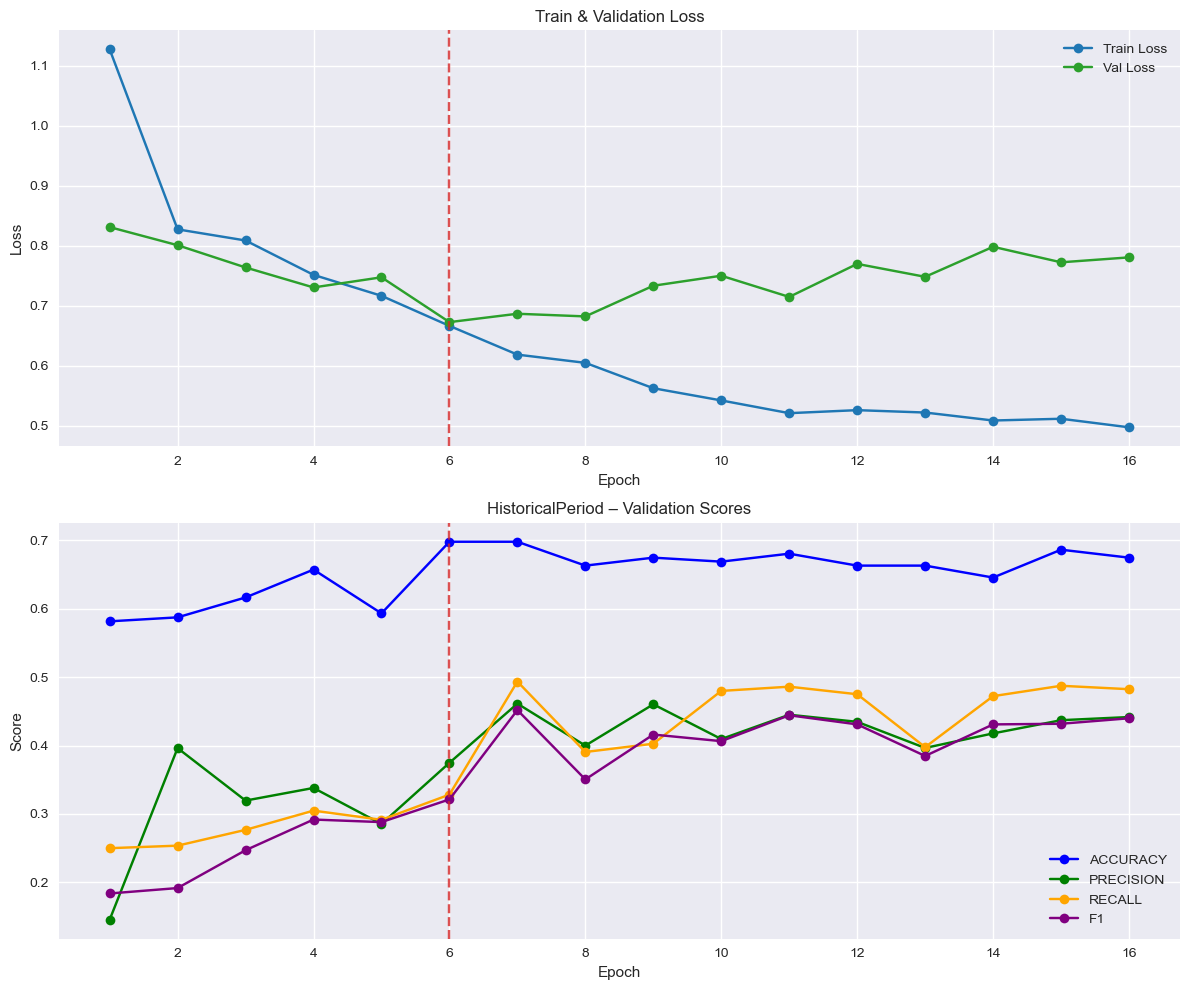



** FEATURE SET: VIT **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 934.07it/s, loss=0.8185]


** Early stop | ran: 15/50 epochs | final: epoch 05 | train_loss: 0.6992, val_loss: 0.7420, accuracy: [0.67], precision: [0.34], recall: [0.31], f1: [0.31], 


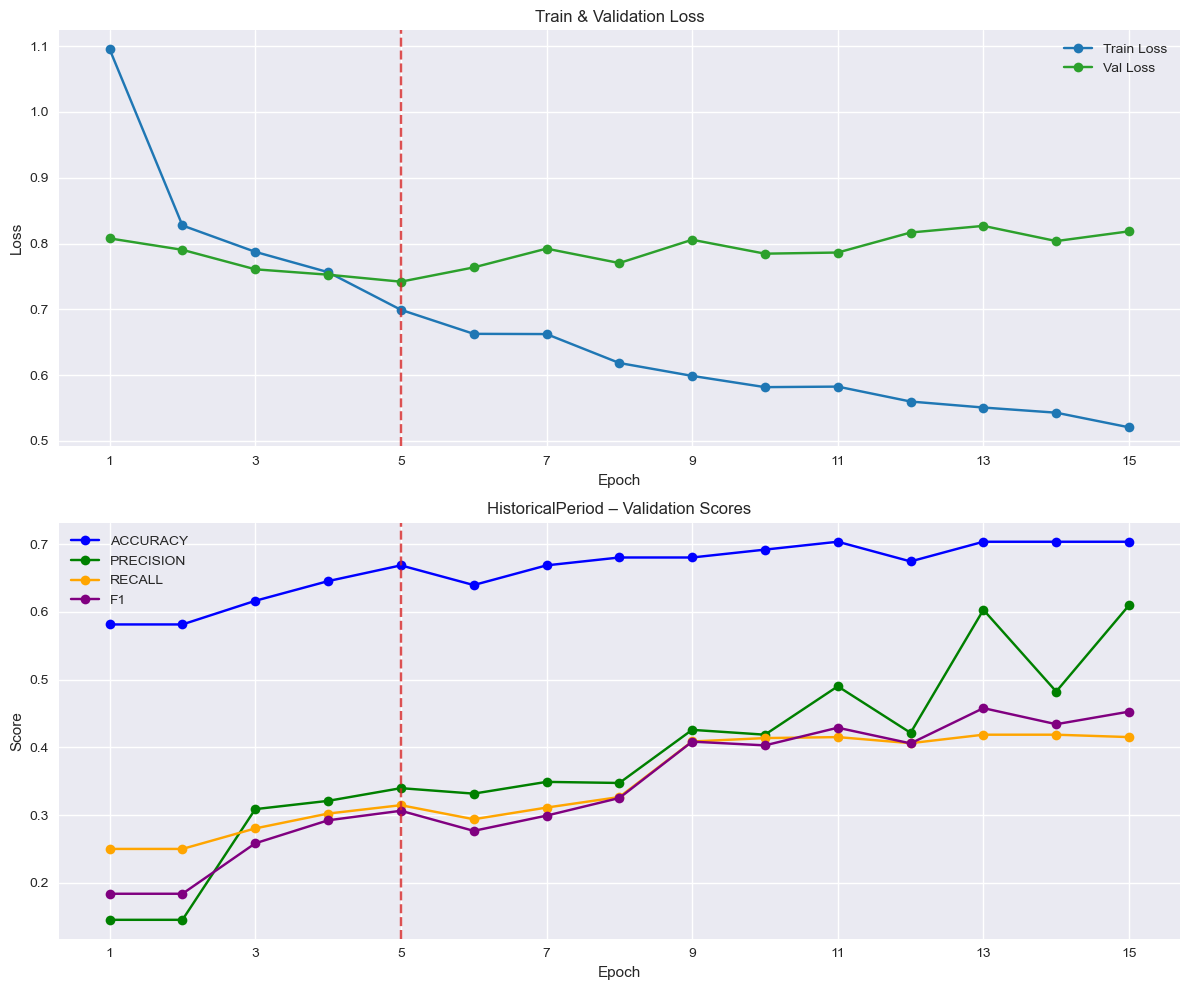



** FEATURE SET: TFIDF + CANNYHOG **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 788.21it/s, loss=0.8088]


** Early stop | ran: 17/50 epochs | final: epoch 07 | train_loss: 0.5082, val_loss: 0.5472, accuracy: [0.75], precision: [0.38], recall: [0.39], f1: [0.38], 


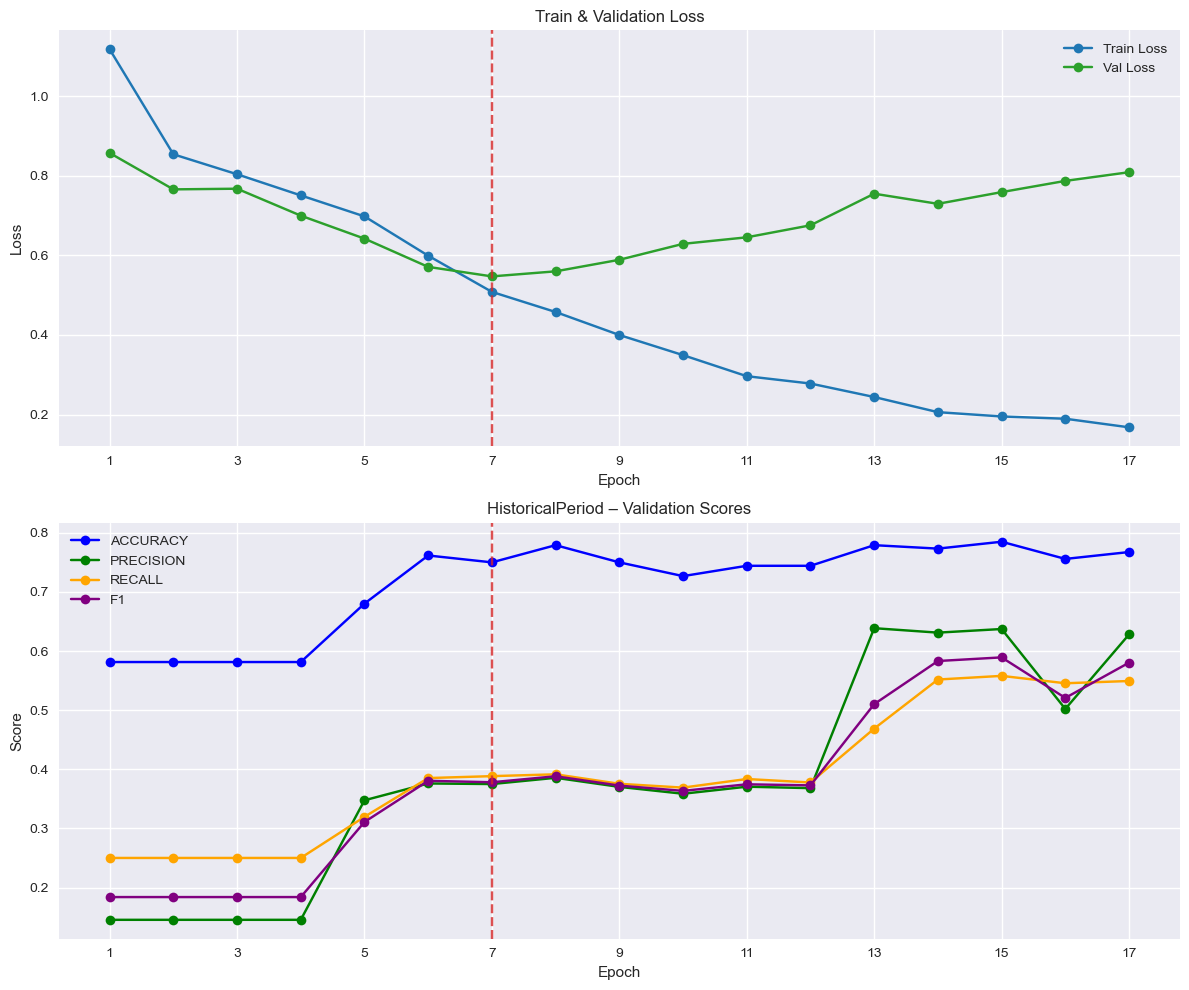



** FEATURE SET: TFIDF + RESNET **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1195.19it/s, loss=0.8030]


** Early stop | ran: 15/50 epochs | final: epoch 05 | train_loss: 0.3997, val_loss: 0.5220, accuracy: [0.78], precision: [0.40], recall: [0.39], f1: [0.39], 


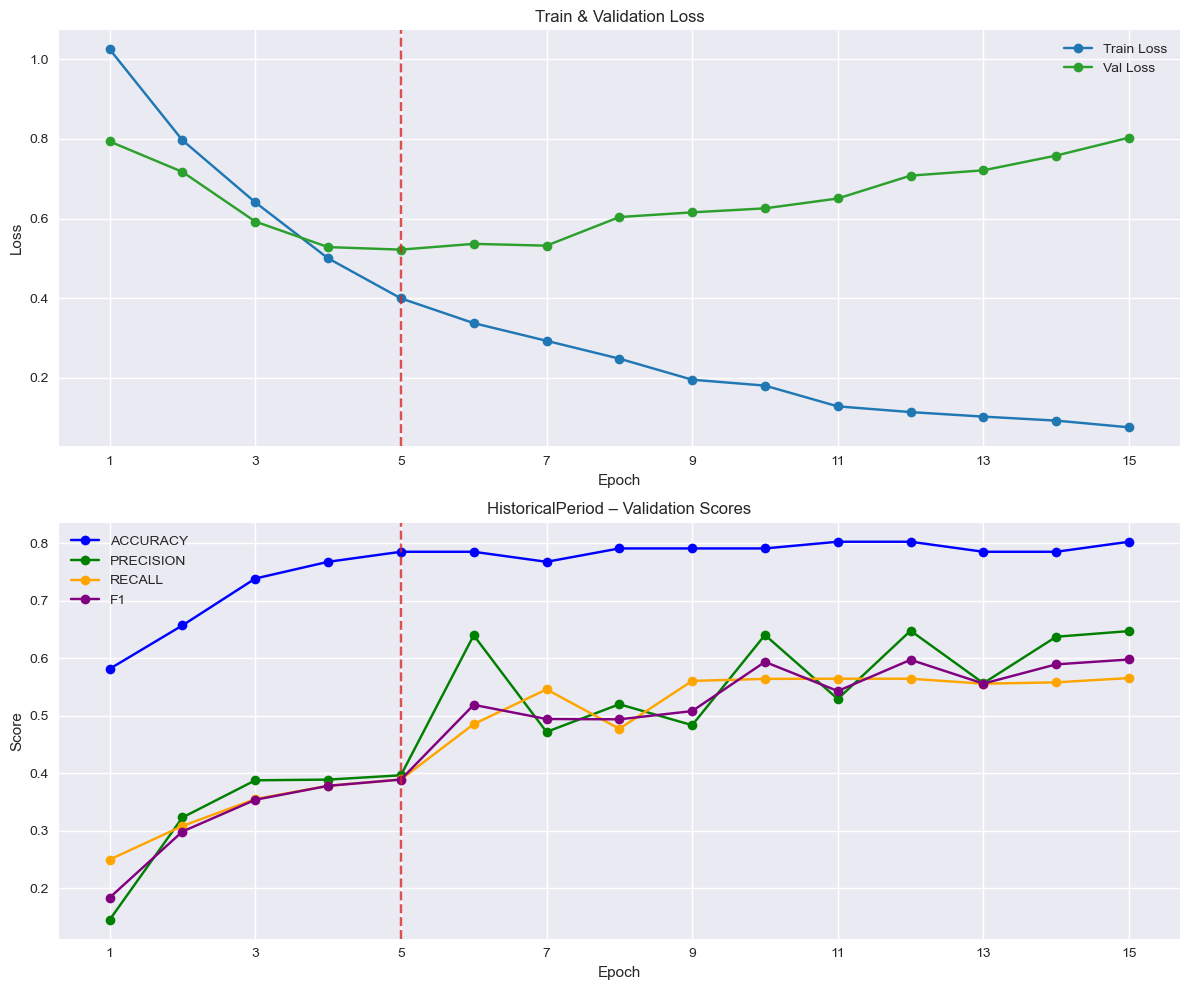



** FEATURE SET: TFIDF + VIT **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 869.23it/s, loss=0.8039]


** Early stop | ran: 15/50 epochs | final: epoch 05 | train_loss: 0.4266, val_loss: 0.5293, accuracy: [0.79], precision: [0.40], recall: [0.39], f1: [0.39], 


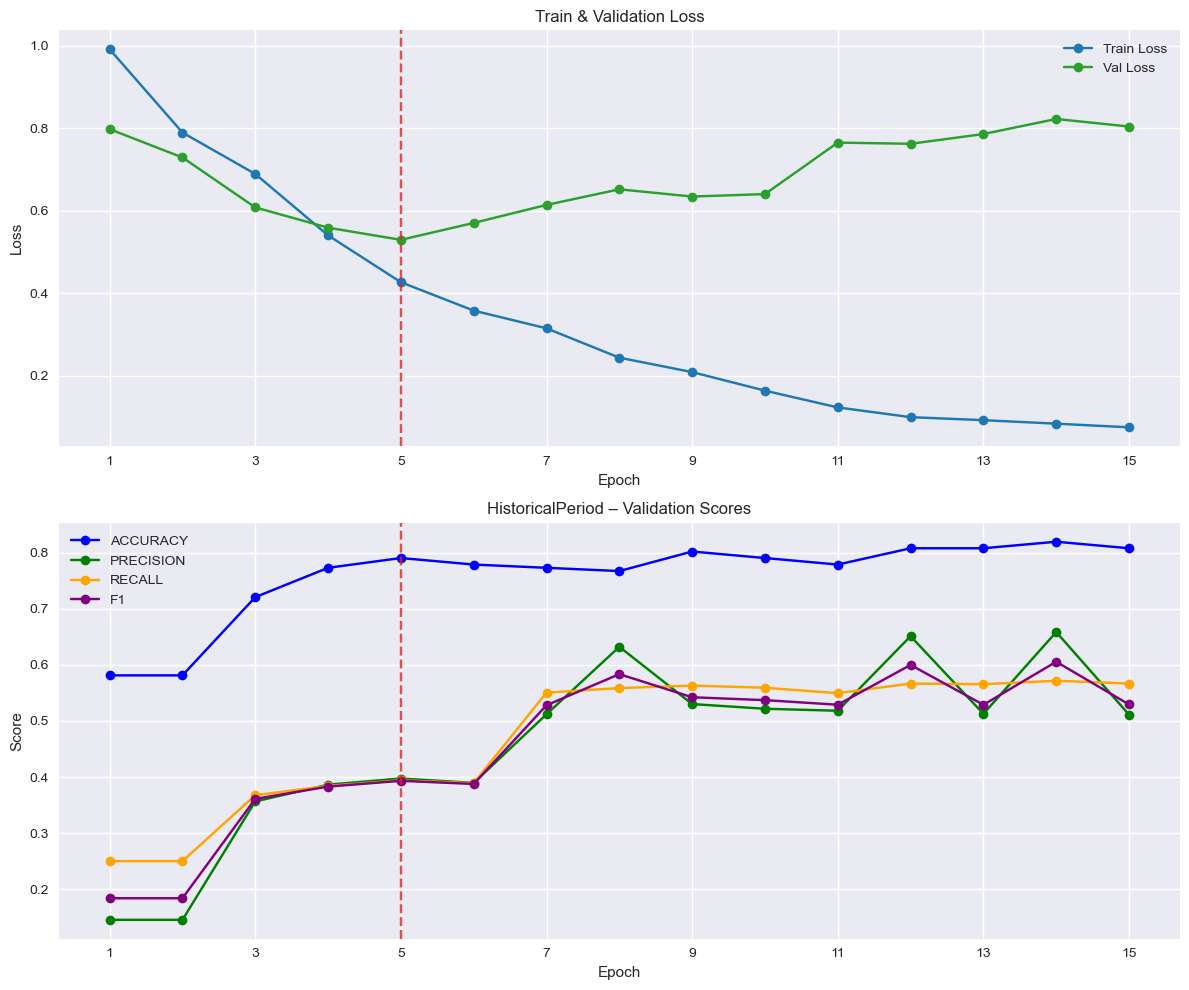



** FEATURE SET: BERT + CANNYHOG **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 743.63it/s, loss=0.6912]


** Early stop | ran: 35/50 epochs | final: epoch 25 | train_loss: 0.5455, val_loss: 0.6119, accuracy: [0.73], precision: [0.36], recall: [0.36], f1: [0.36], 


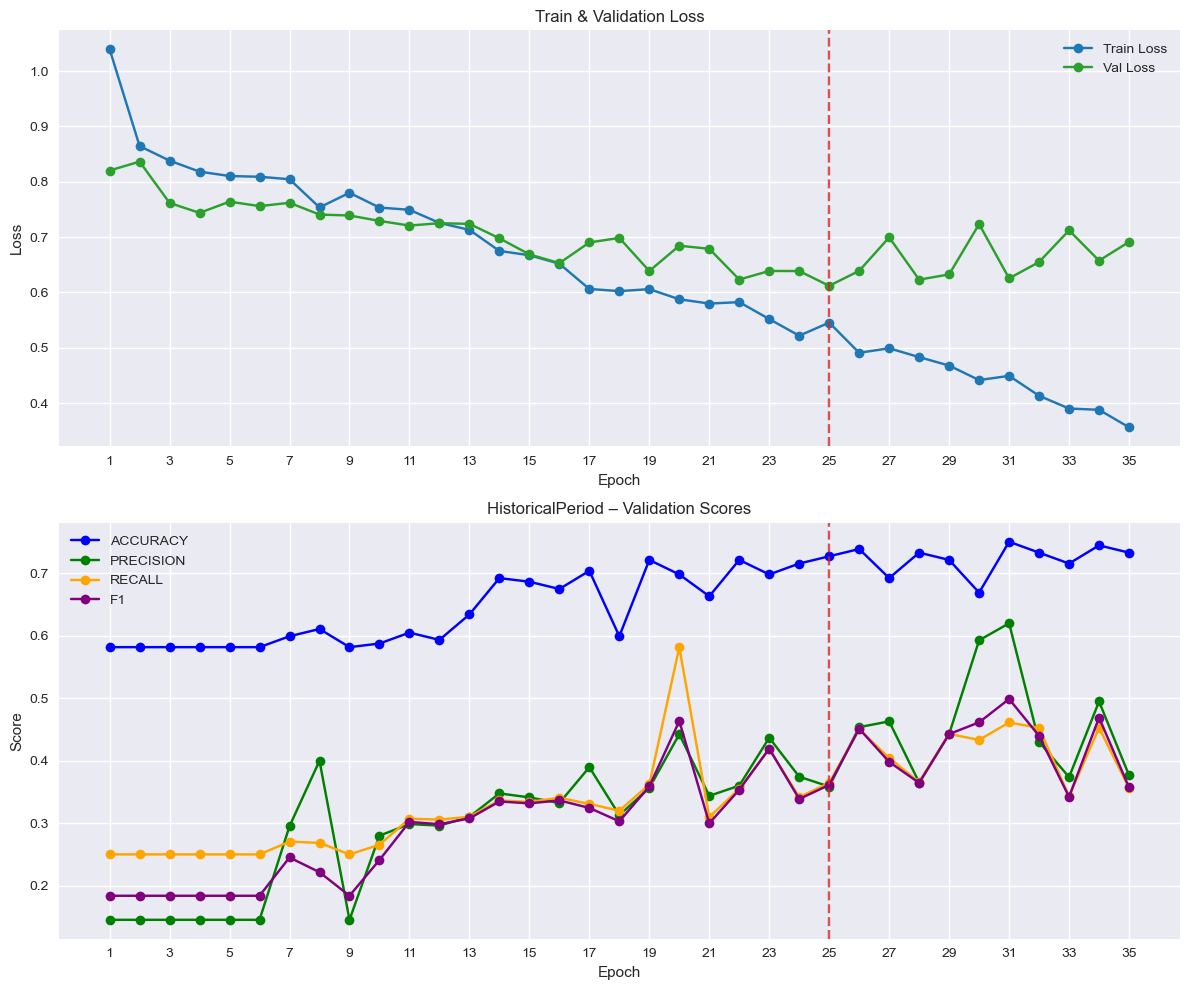



** FEATURE SET: BERT + RESNET **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 838.30it/s, loss=0.7657]


** Early stop | ran: 17/50 epochs | final: epoch 07 | train_loss: 0.5959, val_loss: 0.6482, accuracy: [0.74], precision: [0.50], recall: [0.45], f1: [0.46], 


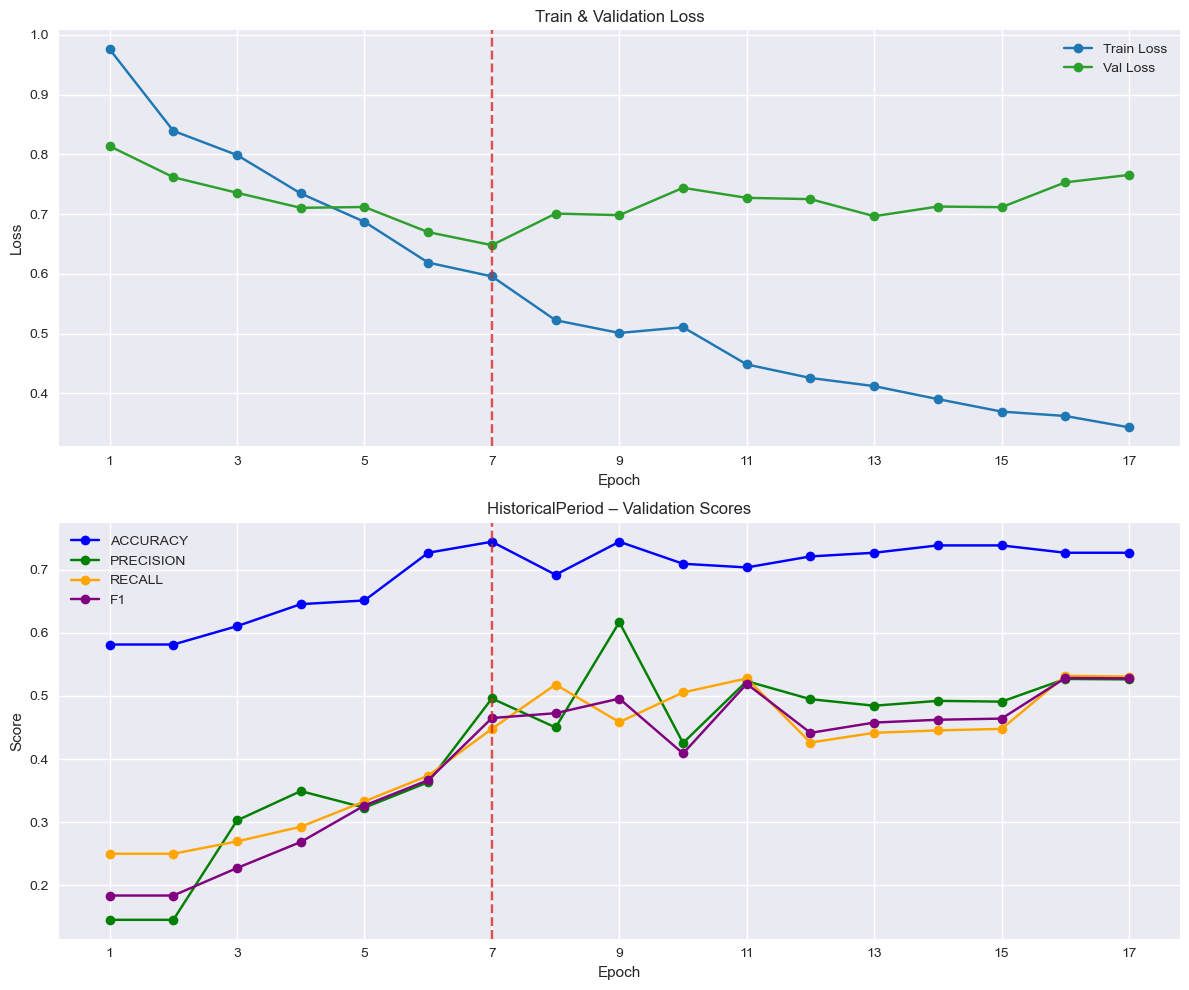



** FEATURE SET: BERT + VIT **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 989.30it/s, loss=0.8224]


** Early stop | ran: 19/50 epochs | final: epoch 09 | train_loss: 0.5888, val_loss: 0.7124, accuracy: [0.75], precision: [0.38], recall: [0.37], f1: [0.37], 


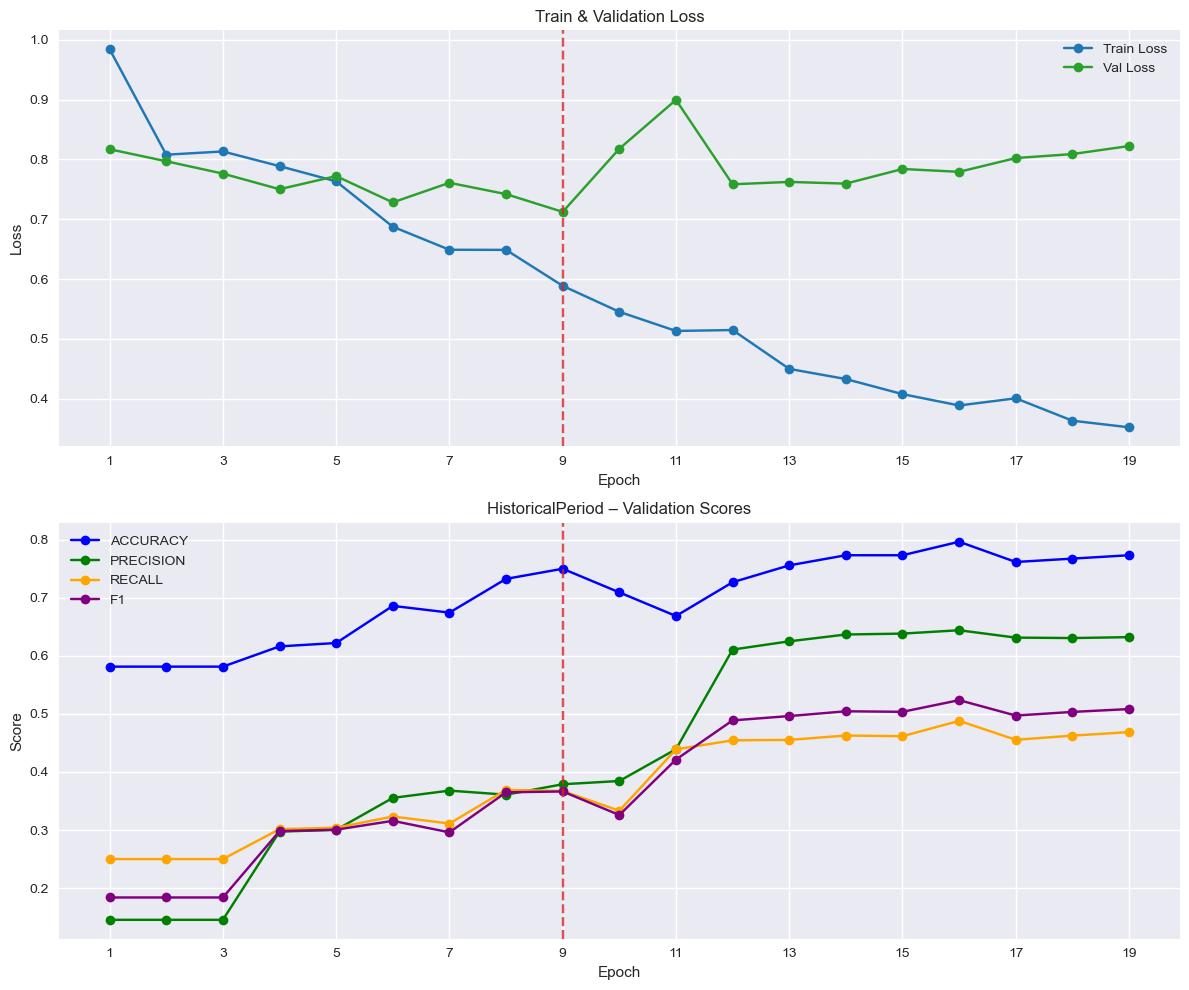

In [20]:
for ft, model in models.items():
    # if ft != "bert": continue
    print(f"\n\n** FEATURE SET: {ft.upper()} **")
    models[ft], history = train(model, loaders["train"][ft], loaders["val"][ft], criterion, metrics, patience=10)
    plot_history(history, [target])

In [21]:
history

{'train_loss': array([0.9840599 , 0.8079034 , 0.81328994, 0.78877914, 0.763316  ,
        0.68756807, 0.6490781 , 0.64887327, 0.5888006 , 0.5454033 ,
        0.5134379 , 0.51497877, 0.45006627, 0.43311   , 0.40791664,
        0.3889404 , 0.40093026, 0.363502  , 0.35244972], dtype=float32),
 'val_loss': array([0.8169874 , 0.7969274 , 0.77627796, 0.7502471 , 0.77211046,
        0.72822005, 0.7609568 , 0.74202704, 0.7123857 , 0.81784093,
        0.8994761 , 0.7584727 , 0.7624086 , 0.7595567 , 0.78400564,
        0.7792611 , 0.80225056, 0.8089377 , 0.8223696 ], dtype=float32),
 'scores': {'accuracy': array([[0.5813953 ],
         [0.5813953 ],
         [0.5813953 ],
         [0.61627907],
         [0.622093  ],
         [0.68604654],
         [0.6744186 ],
         [0.73255813],
         [0.75      ],
         [0.7093023 ],
         [0.6686047 ],
         [0.7267442 ],
         [0.75581396],
         [0.7732558 ],
         [0.7732558 ],
         [0.79651165],
         [0.7616279 ],
       